In [1]:
from src.depth import DepthModel
from src.warp import anim_frame_warp_3d, AnimArgs
import torch
import cv2
from matplotlib import pyplot as plt
import torch
from diffusers import StableDiffusionImg2ImgPipeline
import PIL
import numpy as np
from functools import reduce
import math
import src.py3d_tools as p3d
import torch
from einops import rearrange
from IPython import display

e:\Projects\deforumed-walk\.venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
depth_model = DepthModel(torch.device("cuda"), "../models/dpt_large_384.pt")

In [24]:
input_tensor = torch.Tensor([[[
    [1,2],
    [3,255],
]]])
print(input_tensor)
grid_tensor = torch.Tensor([[
    [[-0.5,-0.5],[0.5,0.5]],
    [[-0.5,0.5],[0.5,-0.5]],
]])

torch.nn.functional.grid_sample(input_tensor, grid_tensor, padding_mode="zeros")

tensor([[[[  1.,   2.],
          [  3., 255.]]]])


tensor([[[[  1., 255.],
          [  3.,   2.]]]])

In [13]:
identity_2d_batch = torch.tensor(
    [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0]]
).unsqueeze(0)
identity_2d_batch

tensor([[[1., 0., 0.],
         [0., 1., 0.]]])

In [14]:
coords_2d = torch.nn.functional.affine_grid(
    identity_2d_batch, [1, 1, 2,2], align_corners=False
)
coords_2d

tensor([[[[-0.5000, -0.5000],
          [ 0.5000, -0.5000]],

         [[-0.5000,  0.5000],
          [ 0.5000,  0.5000]]]])

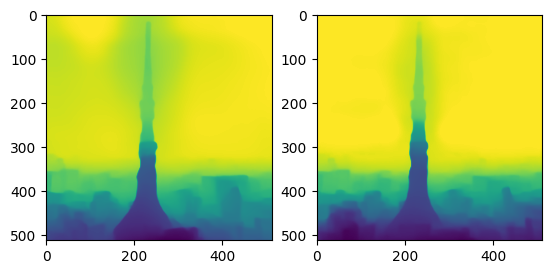

In [40]:
prev_img_cv2 = cv2.imread("../data/tower0.png")
depth_tensor_rgb = depth_model.predict(prev_img_cv2[:,:,::-1])
depth_tensor_bgr = depth_model.predict(prev_img_cv2)

fig, axs = plt.subplots(1, 2)
axs[0].imshow(depth_tensor_rgb.cpu())
axs[1].imshow(depth_tensor_bgr.cpu())

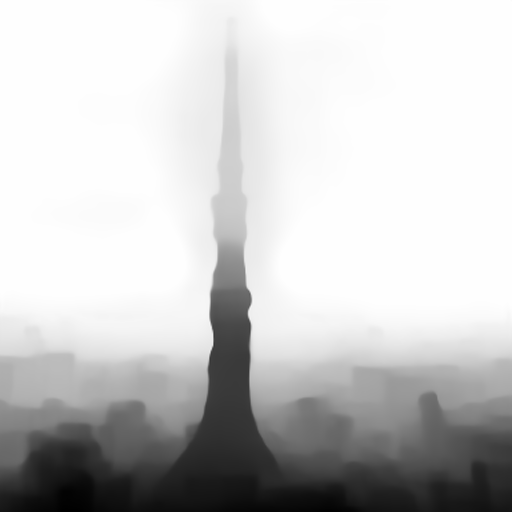

In [27]:
def normalize_dsd_depth(dsd_depth):
    depth_norm = dsd_depth - dsd_depth.min()
    depth_norm = depth_norm
    depth_norm = depth_norm / depth_norm.max()
    depth_norm = depth_norm * 255

    return depth_norm

depth_norm = normalize_dsd_depth(depth_tensor)
depth_norm = depth_norm.cpu().numpy().astype(np.uint8)
img = PIL.Image.fromarray(depth_norm)
img

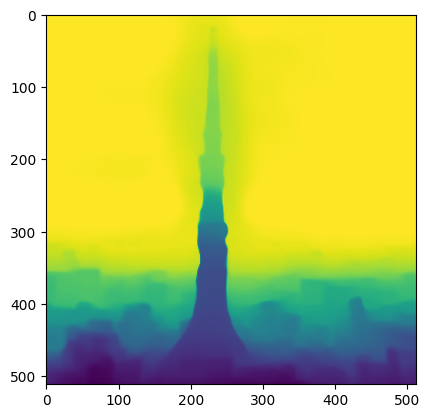

In [34]:
plt.imshow(depth_tensor.cpu())

In [34]:
device = torch.device("cuda")

translate = [0, 0,0]
rotate_xyz = [0,0,0]
rot_mat = p3d.euler_angles_to_matrix(
    torch.tensor(rotate_xyz), "XYZ"
).unsqueeze(0)

# adapted and optimized version of transform_image_3d from Disco Diffusion https://github.com/alembics/disco-diffusion
w, h = prev_img_cv2.shape[1], prev_img_cv2.shape[0]

aspect_ratio = float(w) / float(h)
near = 200,
far = 10_000
fov_deg = 90

persp_cam_old = p3d.FoVPerspectiveCameras(
    near, far, aspect_ratio, fov=fov_deg, degrees=True, device=device
)
persp_cam_new = p3d.FoVPerspectiveCameras(
    near,
    far,
    aspect_ratio,
    fov=fov_deg,
    degrees=True,
    R=rot_mat,
    T=torch.tensor([translate]),
    device=device,
)

# range of [-1,1] is important to torch grid_sample's padding handling
y, x = torch.meshgrid(
    torch.linspace(-1.0, 1.0, h, dtype=torch.float32, device=device),
    torch.linspace(-1.0, 1.0, w, dtype=torch.float32, device=device),
)
if depth_tensor is None:
    z = torch.ones_like(x)
else:
    z = torch.as_tensor(depth_tensor, dtype=torch.float32, device=device)
xyz_old_world = torch.stack((x.flatten(), y.flatten(), z.flatten()), dim=1)

xyz_old_cam_xyz = persp_cam_old.get_full_projection_transform().transform_points(
    xyz_old_world
)
xyz_old_cam_xy = xyz_old_cam_xyz[:, 0:2]

xyz_new_cam_xyz = persp_cam_new.get_full_projection_transform().transform_points(
    xyz_old_world
)
xyz_new_cam_xy = xyz_new_cam_xyz[:, 0:2]

offset_xy = xyz_new_cam_xy - xyz_old_cam_xy
# affine_grid theta param expects a batch of 2D mats. Each is 2x3 to do rotation+translation.
identity_2d_batch = torch.tensor(
    [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0]], device=device
).unsqueeze(0)
# coords_2d will have shape (N,H,W,2).. which is also what grid_sample needs.
coords_2d = torch.nn.functional.affine_grid(
    identity_2d_batch, [1, 1, h, w], align_corners=False
)
offset_coords_2d = coords_2d - torch.reshape(offset_xy, (h, w, 2)).unsqueeze(0)

image_tensor = rearrange(
    torch.from_numpy(prev_img_cv2.astype(np.float32)), "h w c -> c h w"
).to(device)
new_image = torch.nn.functional.grid_sample(
    image_tensor.add(1 / 512 - 0.0001).unsqueeze(0),
    offset_coords_2d,
    mode="bicubic",
    padding_mode="border",
    align_corners=False,
)

# convert back to cv2 style numpy array
result = (
    rearrange(new_image.squeeze().clamp(0, 255), "c h w -> h w c")
    .cpu()
    .numpy()
    .astype(prev_img_cv2.dtype)
)

tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')


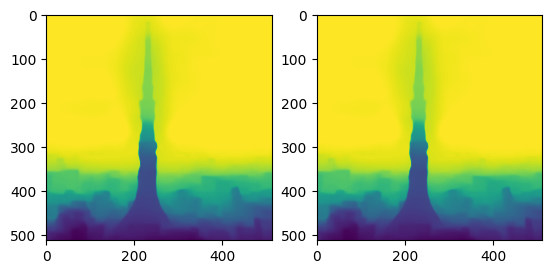

In [37]:
old_depth = depth_tensor.unsqueeze(0)
new_depth = torch.nn.functional.grid_sample(
    old_depth.unsqueeze(0),
    offset_coords_2d,
    mode="bicubic",
    padding_mode="border",
    align_corners=False,
)
fig, axs = plt.subplots(1,2)
axs[0].imshow(old_depth[0].cpu())
axs[1].imshow(new_depth[0][0].cpu())


In [33]:
depth_norm = normalize_dsd_depth(new_depth[0][0])

tensor(255., device='cuda:0')